<a href="https://colab.research.google.com/github/finesketch/deep_learning/blob/main/4.%20Sequences%2C%20Time%20Series%20and%20Prediction/Course4_Part4_Lesson3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [2]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-12-19 15:12:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 172.217.7.176, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-12-19 15:12:41 (88.4 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



time: 0
sunspot: 96.7
other1: 1749-01-31
time: 1
sunspot: 104.3
other1: 1749-02-28
time: 2
sunspot: 116.7
other1: 1749-03-31
time: 3
sunspot: 92.8
other1: 1749-04-30
time: 4
sunspot: 141.7
other1: 1749-05-31
time: 5
sunspot: 139.2
other1: 1749-06-30
time: 6
sunspot: 158.0
other1: 1749-07-31
time: 7
sunspot: 110.5
other1: 1749-08-31
time: 8
sunspot: 126.5
other1: 1749-09-30


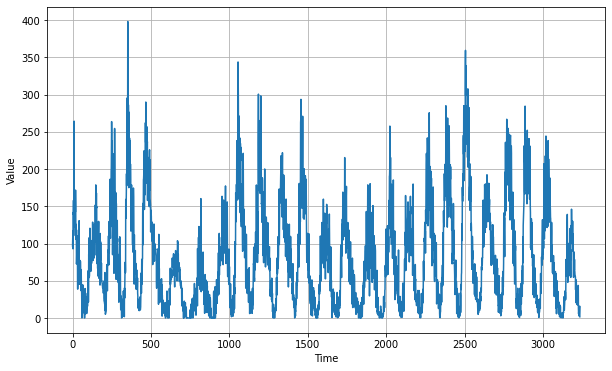

In [6]:
import csv

time_step = []
sunspots = []
counter = 0

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))
    counter = counter + 1
    if counter < 10:
      print('time: ' + str(row[0]))
      print('sunspot: ' + str(row[2]))
      print('other1: ' + str(row[1]))

  series = np.array(sunspots)
  time = np.array(time_step)

  plt.figure(figsize=(10,6))
  plot_series(time, series)

In [7]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(20, input_shape=[window_size], activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1)
])

In [14]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))

In [15]:
model.fit(dataset, epochs=100, verbose=0)

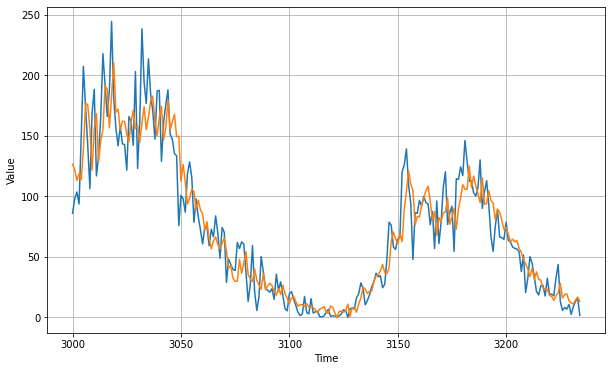

In [16]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

15.403015

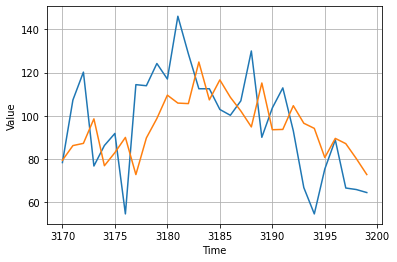

In [21]:
plot_series(time_valid[170:200], x_valid[170:200])
plot_series(time_valid[170:200], results[170:200])